# Build your own Gaussian process (GP lab part 3)

**Machine Learning, University of Zaragoza, Ruben Martinez-Cantin**

This lab exercise allows you to implement your own Gaussian processes for regression. You can compare the results here with the results you got from the exercise with GPy.

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["font.size"] = 16

# Function for plotting/shading.
def GaussPDFscaled(y, m, s):
  return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

In [2]:
# Optimization function. Used for the hyperparameter tuning/learning
from scipy.optimize import dual_annealing

# Cholesky decomposition functions
from scipy.linalg import cho_solve, cho_factor

We are going to use the [same data](https://drive.google.com/file/d/1wGlqnkXU-Fv6Tu8k0x3a5BR6CieLm_06/view?usp=sharing) used in the regression examples from the course slides. Of course, you can, and you should, try with a different dataset, like the [weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

Note: if you use your own data set, use only one data dimension. GPs are able to perform multidimensional regression, but the code is slightly longer and more complicated. Also, the implementation that we are using is not robust to outliers.

In [3]:
!wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/data_gp.npz
!wget https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat

--2024-10-26 10:58:43--  https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/data_gp.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060 (1.0K) [application/octet-stream]
Saving to: ‘data_gp.npz’

data_gp.npz         100%[===================>]   1.04K  --.-KB/s    in 0s      

2024-10-26 10:58:43 (40.2 MB/s) - ‘data_gp.npz’ saved [1060/1060]

--2024-10-26 10:58:44--  https://raw.githubusercontent.com/rmcantin/gp_lab/main/datasets/weightdata_clean.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4877 (4.8K) [app

In [6]:
use_data_gp = True

# Load the data from the file
if use_data_gp:
  data = np.load('data_gp.npz')
  dataX = data['X']
  dataY = data['Y']
else:
  # You can also use the weight dataset.
  # Note that for the weight dataset we select a random subset of just 100 points
  # to avoid large computation times.
  data=scipy.io.loadmat('weightdata_clean.mat')

  # random selection of 100 points
  id = np.array(range(len(data['dat'])))
  np.random.shuffle(id)
  id = id[:100]

  dataX = np.atleast_2d(data['dat'][id,0]).T
  dataY = np.atleast_2d(data['dat'][id,1]).T

# We normalize the data.
# This is better to adjust the lengthscale and also for plotting
dataX -= dataX.min()
dataX /= dataX.max() - dataX.min()

# GP implementation
This is the code to implement a GP class. There are already implemented several methods for initialization, plotting, tunning the hyperarameters, etc.

You also have already implemented the Square Exponential kernel
$$
k(x_1,x_2) = \sigma_s^2 \cdot \exp{\left(\frac{|x_1-x_2|^2}{2l^2}\right)}
$$

## Prediction
Your job is to compute the prediciton function to return both the predicted mean $\widehat{f_*}$ and variance $\sigma^2_{f_*}$ for a query point $\bf x_*$.

Remember that:
$$
\begin{align}
\widehat{f_*} &= k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y}\\
\sigma^2_{f_*} &= k(x_*,x_*) - k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} k(X, x_*)\\
\end{align}
$$
where the kernel matrix is:
$$
k(X,X) = \left(\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_n) \\
k(x_2,x_1) & \ldots & k(x_2,x_n) \\
\vdots & \ddots & \vdots\\
k(x_n,x_1) & \ldots & k(x_n,x_n)\\
\end{array}\right)
$$
and the correlation vector is:
$$
k(x_*,X) = k(X,x_*)^T = \left(\begin{array}{c}
k(x_1,x_*)\\
k(x_2,x_*)\\
\vdots\\
k(x_n,x_*)\\
\end{array}\right)
$$

For the prediction, remember than in numpy, the matrix multiplication is `A @ B`, the transpose `A.T` and the inverse is `numpy.linalg.inv(A)`.

If you want to try the more efficient method from the slides, you can use the Cholesky decomposition with `L = cho_factor(K)` and the solve command, with is represented in the slides as $L \backslash y$ can be computed `cho_solve(L,y)`. Both functions are loaded from `scipy.linalg`.

## Log-likelihood
If you want to learn the hyperparameters, you also need to implement the log-likelihood method. Again, you can use the straightforward method and implement this equation:

$$
\log p(y|X,\theta) = -\frac{1}{2}\mathbf{y}^T (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y} -\frac{1}{2}\log|k(X,X) + \sigma^2_nI| -  \frac{n}{2}\log 2\pi
$$

where $|k(X,X)|$ is the determinant of the covariance matrix. Or you can implement the version from the slides using the Cholesky decomposition.

Notes:
- The method requires the **negative** log-likelihood because the algorithm that we use for optimization finds the minimum, instead of the maximum.
- You need to recompute the whole covariance matrix every time you compute the log-likelihood because the kernel hyperarameters have changed.
- Usually, it is better to use a gradient based optimization for maximum likelihood, but we use a gradient-free version so you don't need to implement it. :-)



In [ ]:
class GP:
  def __init__(self, X, Y):
    # Store the dataset
    self.X = X
    self.Y = Y

    # Kernel hyperparameters (default values)
    self.ell = 1.0
    self.sigma_s = 1.0

    # Observation noise / likelihood (also hyperparameter)
    self.sigma_n = 1.0


  def kernel(self, x1, x2):
    # Kernel function (Square exponential)
    # Note that x1 and x2 might be vectors of points (vectorized calls)
    ell = self.ell
    sigma = self.sigma_s
    return sigma * np.exp(-0.5*(x1-x2)**2/ell)

  def compute_kernel_matrix(self):
    # Computes the kernel matrix for the dataset points
    X = self.X
    return self.kernel(X, X.T)

  def compute_cross_correlation(self, x):
    # Computes the correlation between the dataset points and a new point x
    X = self.X
    return self.kernel(x, X.T)

  def predict(self, x):
    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUES OF MEAN f* AND COV sigma2_f* EVALUATED AT x
    ###################################################################
    K = self.compute_kernel_matrix() + self.sigma_n ** 2 * np.eye(len(self.X))
    k_star = self.compute_cross_correlation(x)
    K_inv = np.linalg.inv(K)
    mean = k_star @ K_inv @ self.Y
    cov = self.kernel(x, x) - k_star @ K_inv @ k_star.T
    return mean, cov

  def neg_log_likelihood(self, hyperparams):
    # Computes the negative log-likelihood for hyperarameter tuning

    # We assign the hyperparameters that we are evaluating as the GP
    # hyperparameters. If we call the kernel now, it will be with the new
    # hyperparameters.
    self.ell = np.exp(hyperparams[0])
    self.sigma_s = np.exp(hyperparams[1])
    self.sigma_n = np.exp(hyperparams[2])

    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUE OF THE NEGATIVE LOG-LIKELIHOOD.
    # Note that the new leghtscale and sigma are already asigned.
    ###################################################################
    K = self.compute_kernel_matrix() + self.sigma_n ** 2 * np.eye(len(self.X))

    # Inversa de K
    K_inv = np.linalg.inv(K)
    term1 = 0.5 * self.Y.T @ K_inv @ self.Y
    term2 = 0.5 * np.log(np.linalg.det(K))
    term3 = 0.5 * len(self.X) * np.log(2 * np.pi)

    negative_log_likelihood = term1 + term2 + term3

    return negative_log_likelihood

  def tune_hyperparameters(self):
        # Method to optimize the hyperparameters. It will call neg_log_likelihood
        # with several versions of the hyperparameters and return the values with the
        # minimum neg_log_likelihood, that is, the maximum log_likelihood.

        # Trivia: the hyperparameters can be very large or very small.
        # It is very tricky to do so searching uniformly. Instead, we optimize the
        # log(hyperparameter). Intuitively, we are optimizing the order of magnitude.
        # This way, we have more resolution with smaller values, which is what we want.
        bounds = [(-6, 6), (-6, 6), (-6, 6)]
        ret = dual_annealing(self.neg_log_likelihood, bounds)
        if ret.success:
          print("Updating hyperparameters. New values: ", np.exp(ret.x))
          self.ell = np.exp(ret.x[0])
          self.sigma_s = np.exp(ret.x[1])
          self.sigma_n = np.exp(ret.x[2])

        return ret.success

  def plotGP(self):
    # Plotting function. We just take a grid of 100 points in the whole interval
    # and we compute the predicion at those points.
    fig, ax = plt.subplots(1,1)
    xin = np.linspace(-0.2,1.2,100)
    output = [self.predict(x) for x in xin]
    mx, stdp = [np.array([mean for mean, cov in output]).flatten(),
                np.array([np.sqrt(cov) for mean, cov in output]).flatten()]

    yy = np.linspace(dataY.min()-3, dataY.max()+3, 200).reshape([200, 1])
    shadow = GaussPDFscaled(yy, mx, stdp)
    ax.imshow(
        shadow, extent=[-0.2,1.2, dataY.min()-3, dataY.max()+3], aspect="auto", origin="lower", cmap="Blues", alpha=0.4
    )

    ax.plot(xin , mx, "-", color='b')
    ax.plot(xin , mx + 2 * stdp, "-", color='steelblue')
    ax.plot(xin , mx - 2 * stdp, "-", color='steelblue')
    ax.plot(self.X, self.Y, 'ko')

### Explain functions

Predict:

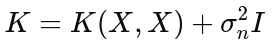


$$\begin{align} K_{star} &= \end{align}$$
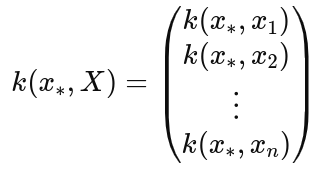


$$\begin{align} K_{inv} &= \end{align}$$
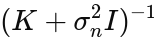

$$
\begin{align}
\widehat{f_*} &= k_{star} k_{inv} \mathbf{y}\\
\sigma^2_{f_*} &= k(x_*,x_*) - k_{star} k_{star}^T\\
\end{align}
$$

neg_log_likelihood:

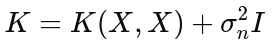




$$\begin{align} K_{inv} &= \end{align}$$
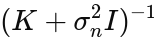

$$\begin{align}term1 &= \end{align}$$

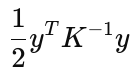

$$\begin{align}term2 &= \end{align}$$

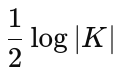

$$\begin{align}term3 &= \end{align}$$

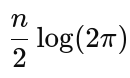

$$\begin{align}negative\_log\_likelihood &= term1 + term2 + term3 \end{align}$$

Here, you have a small code snippet to test your GP with different leghtscales and with tuned hyperparameters.

Updating hyperparameters. New values:  [3.13834648e-02 3.18605148e+01 5.93394727e-01]


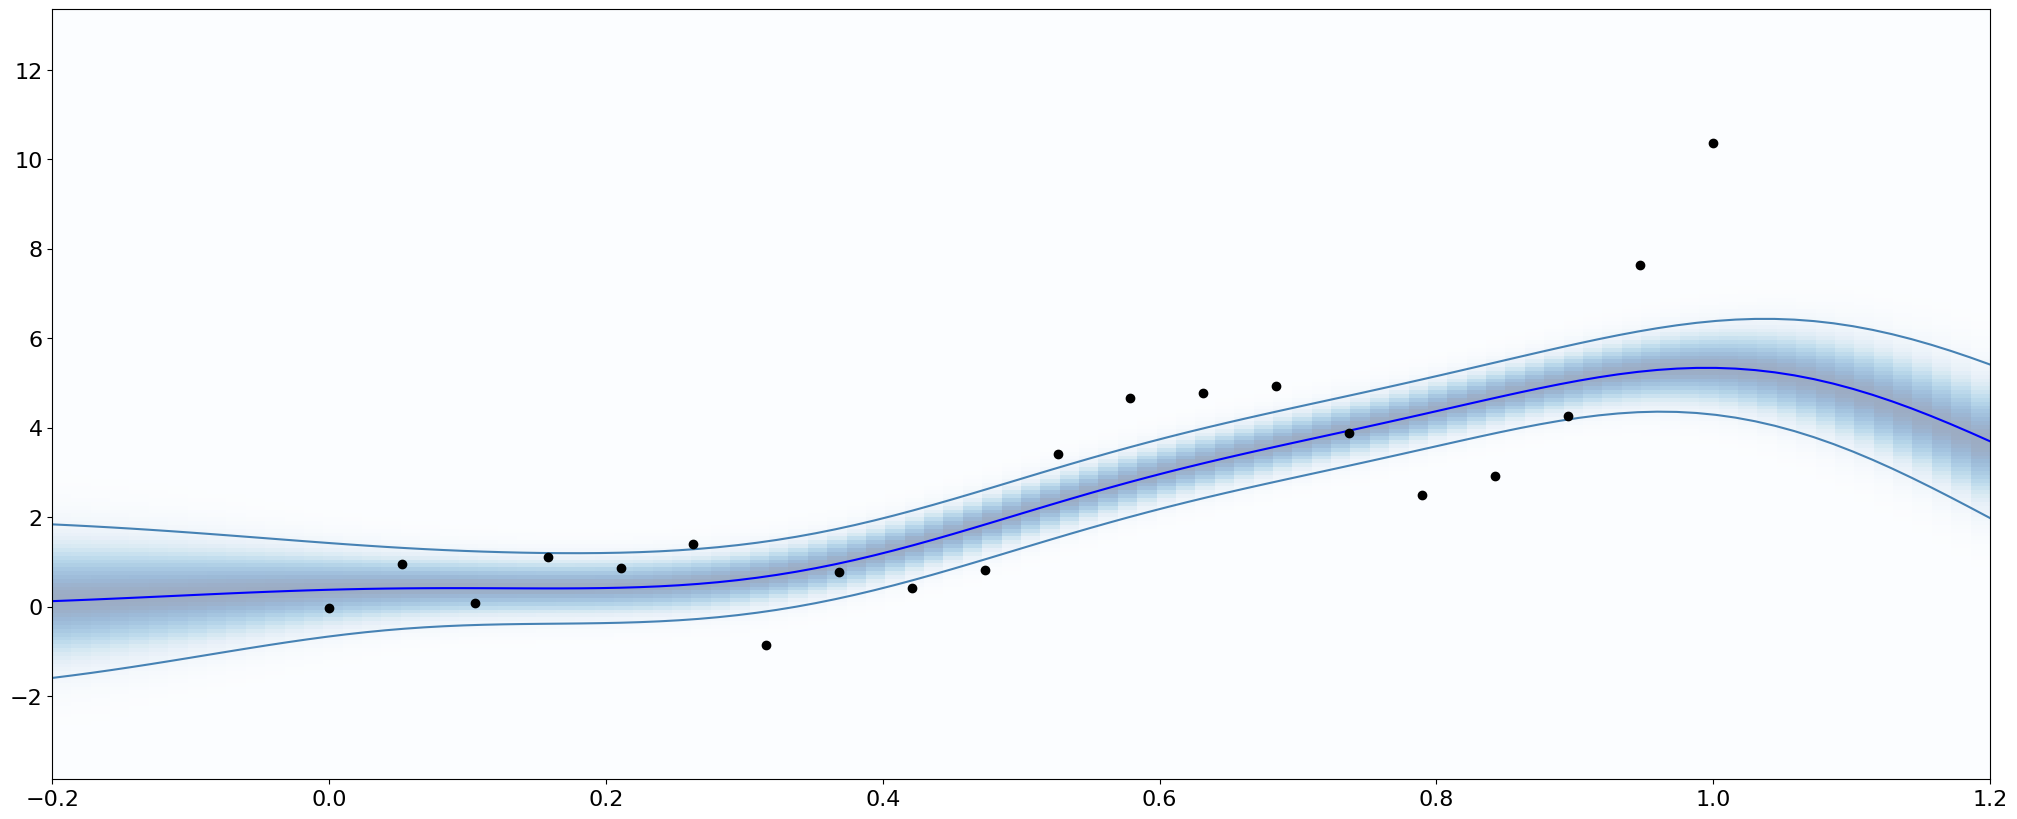

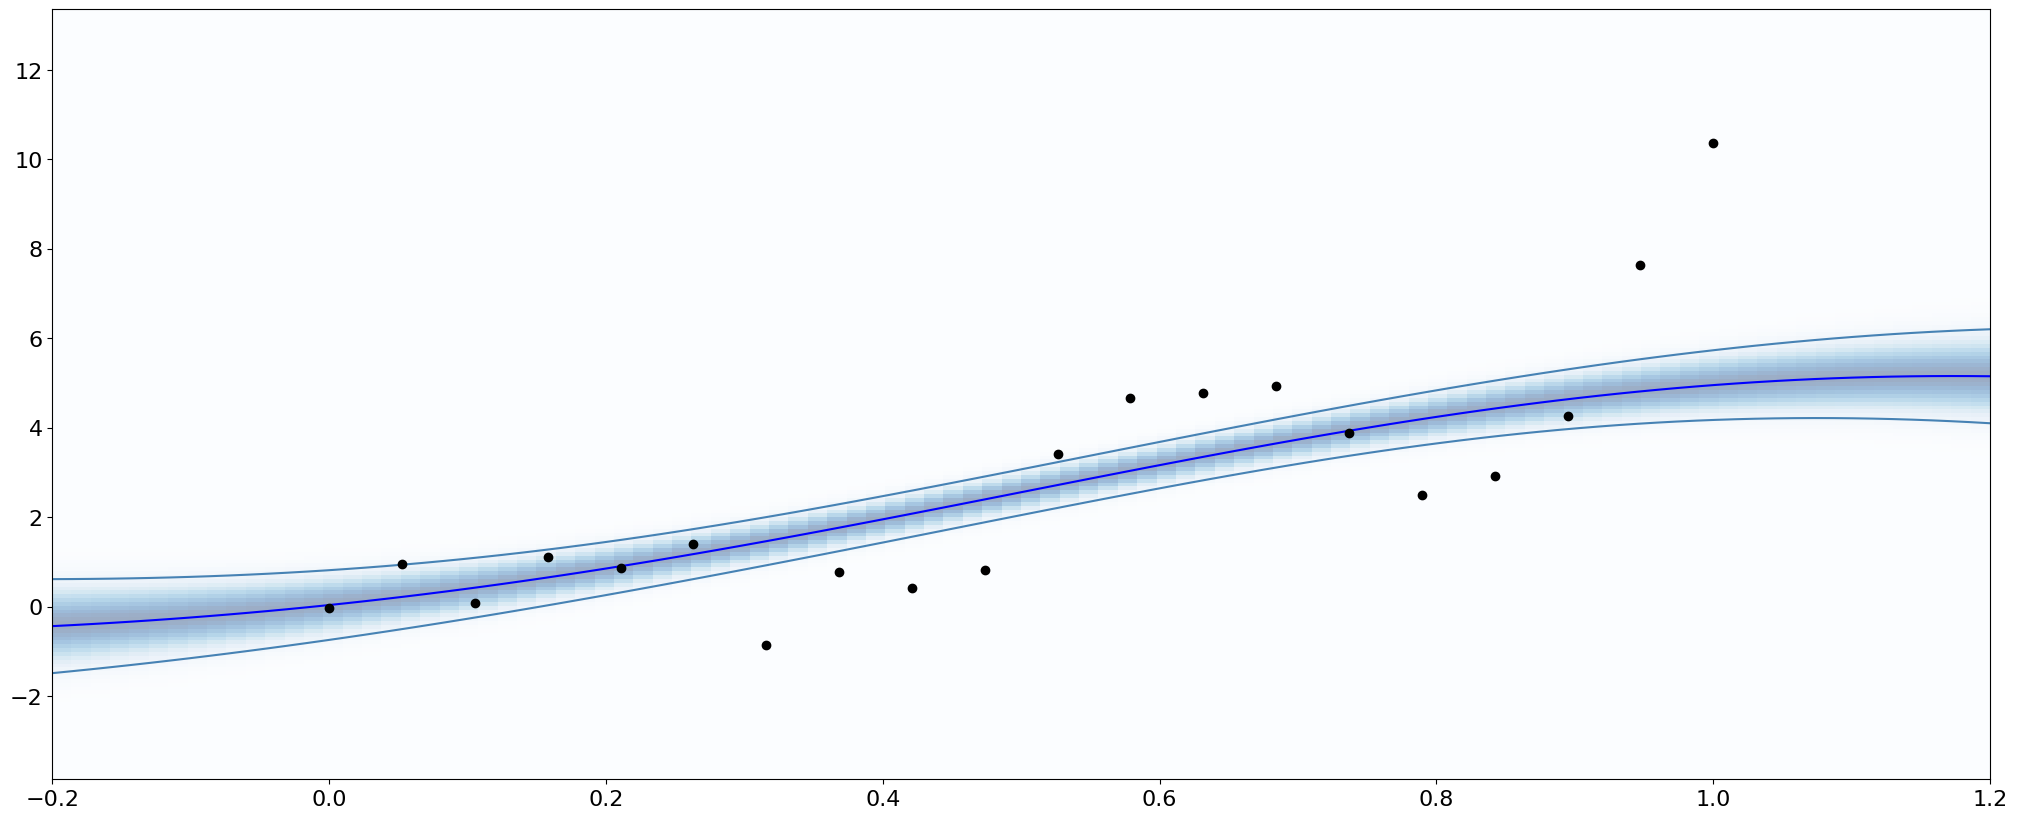

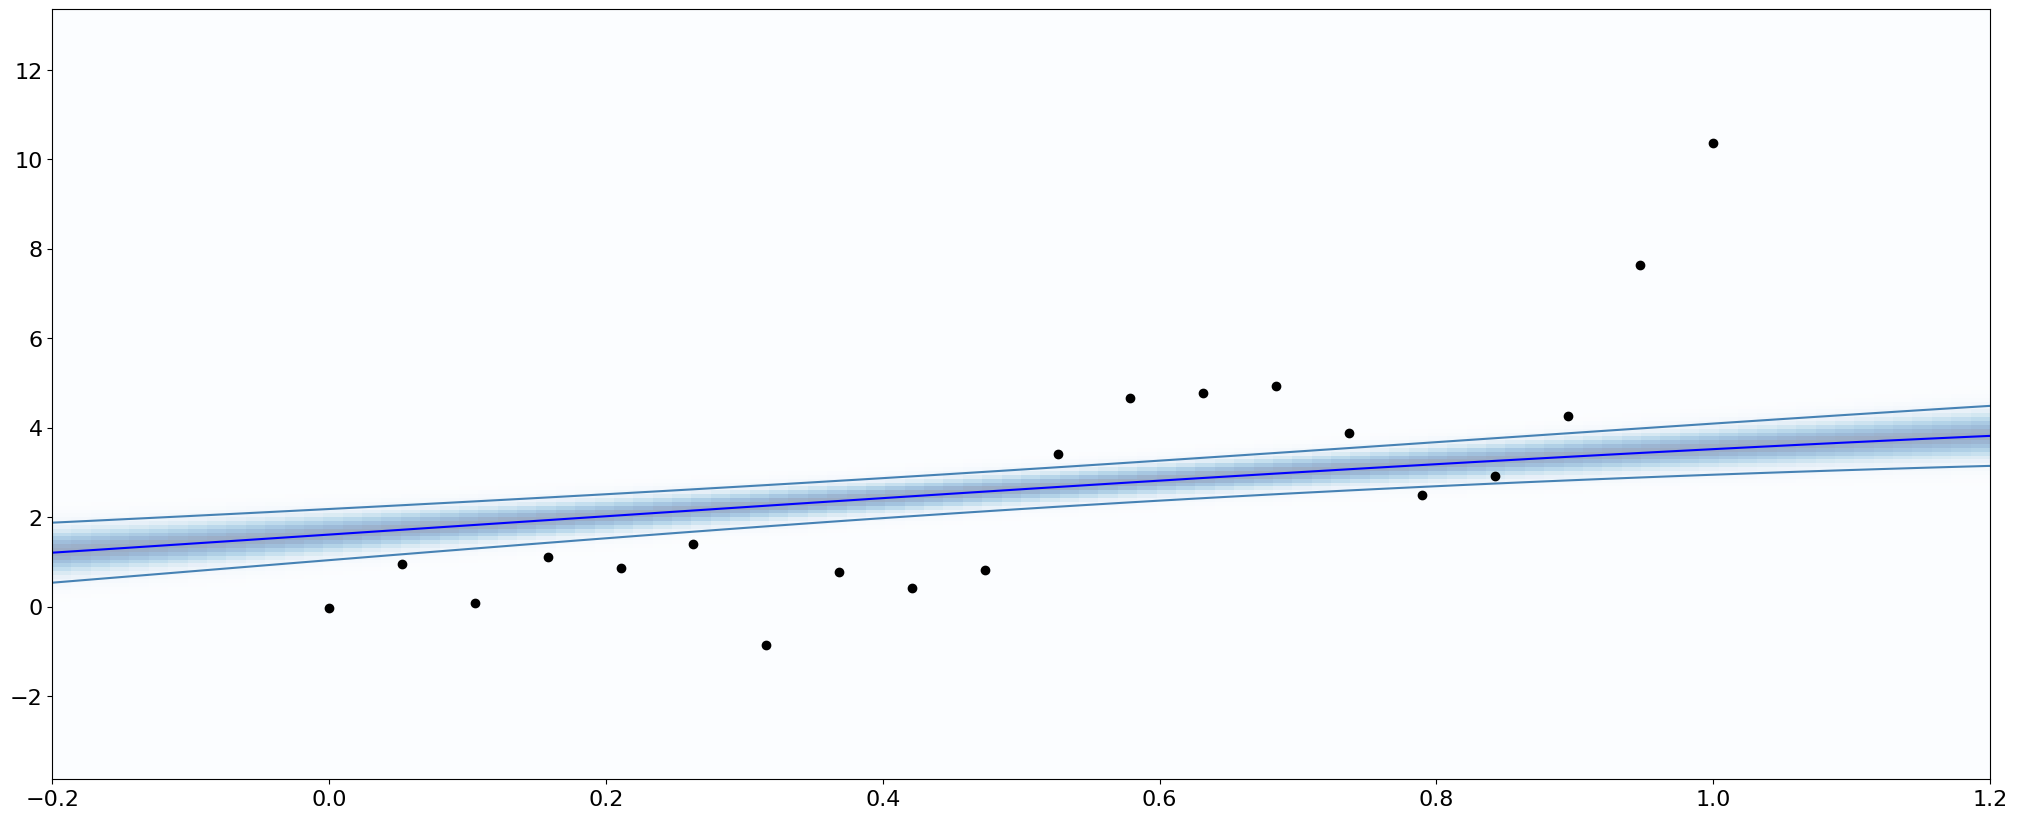

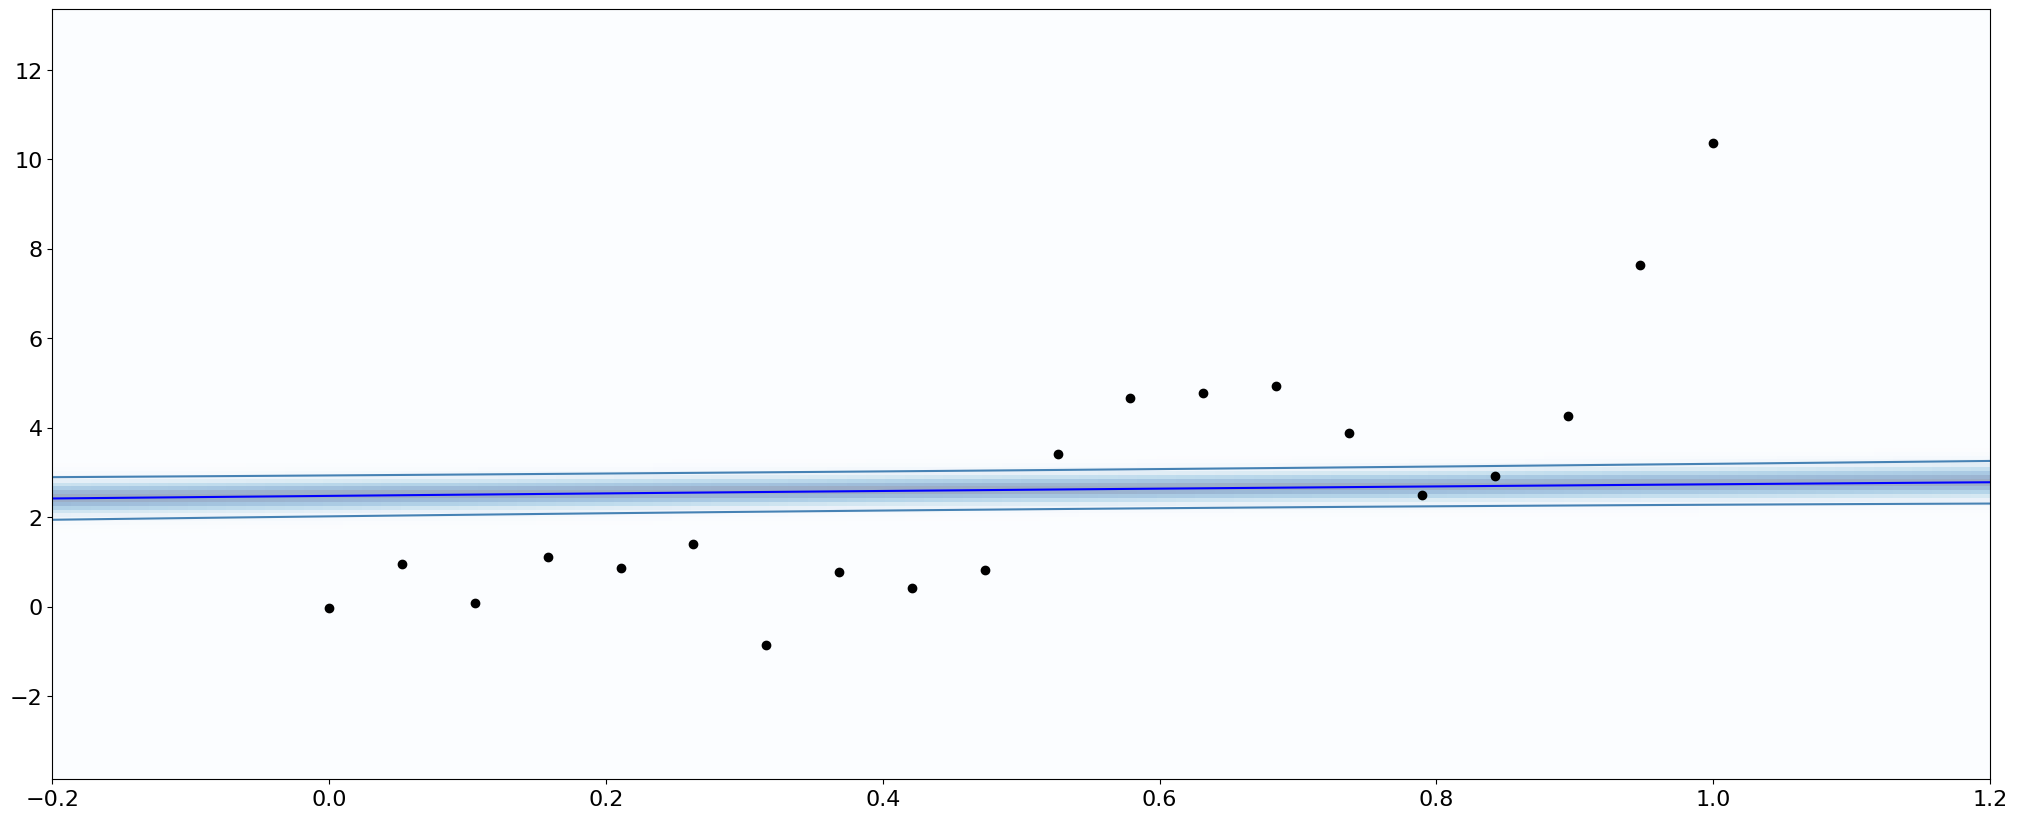

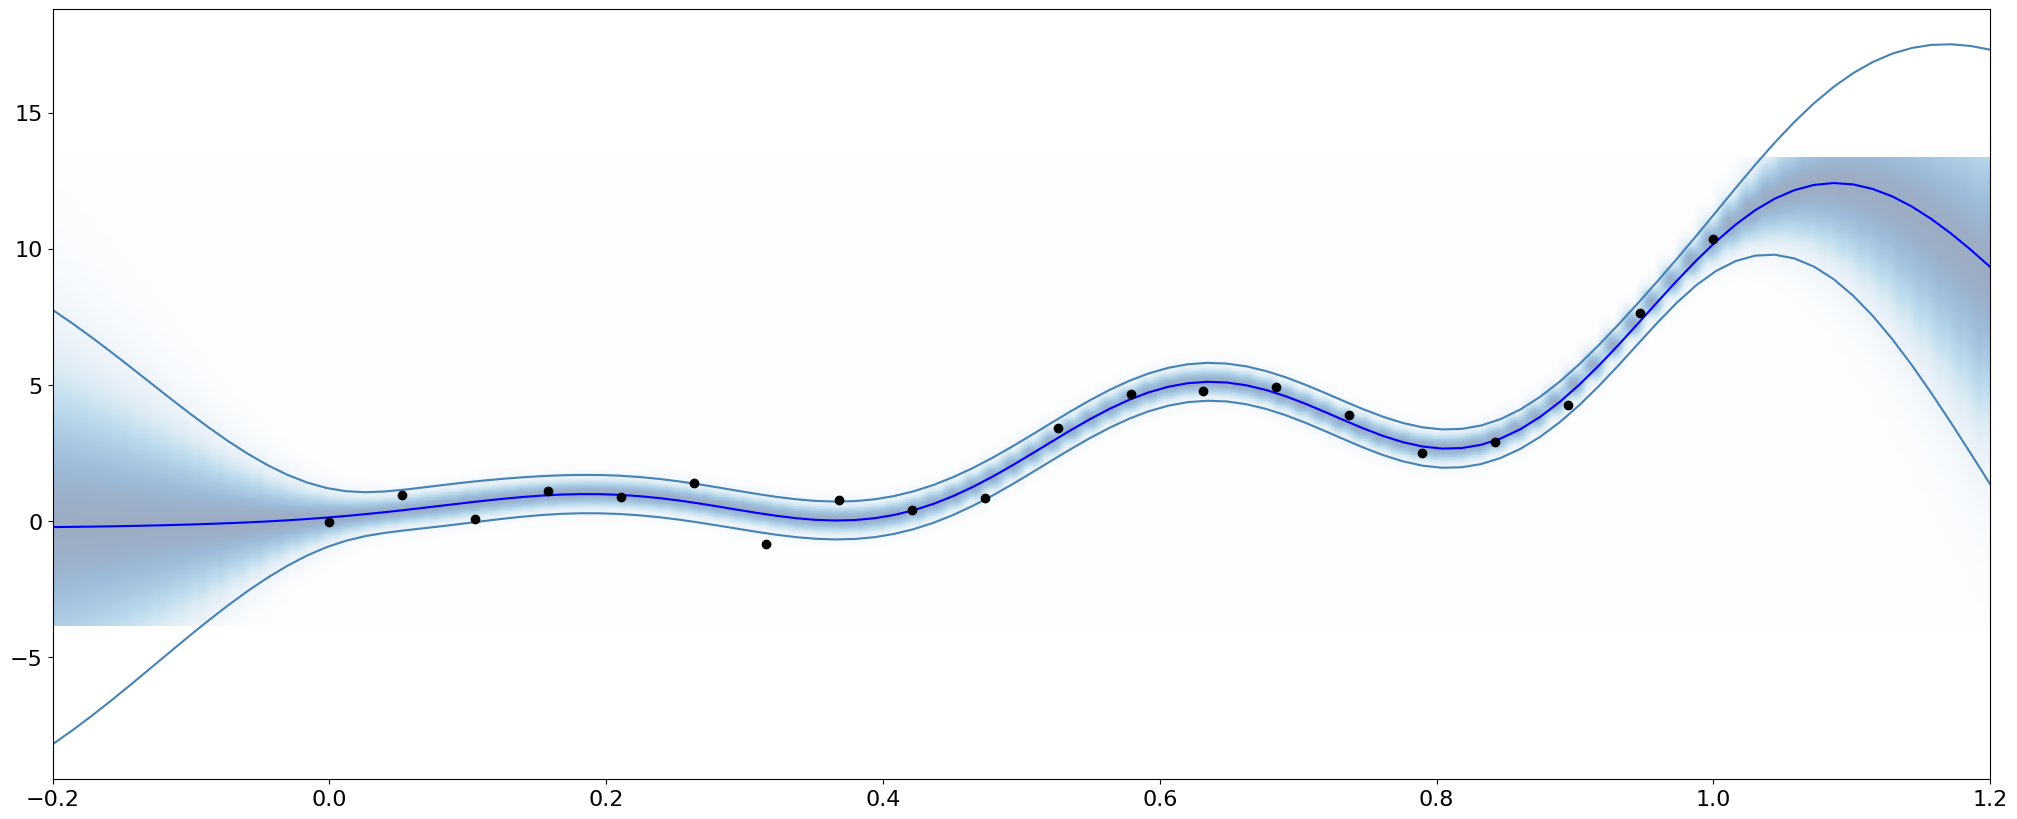

In [ ]:
my_gp = GP(dataX, dataY)
for i in [0.05, 0.5, 5, 50]:
  my_gp.ell = i
  my_gp.plotGP()

my_gp.tune_hyperparameters()
my_gp.plotGP()
plt.show()

# Your tasks

**Choose one between 1. and 2.** There is no extra points for implementing both versions! If you do 1, you can get as much as a 9.0 grade. If you do 2, you can get 10.0 grade.

1. Implement the prediction and log-likelihood methods using the standard equations (with the inverse).

2. (Alternative to 1 for extra points) If you implement the prediction with the Cholesky decompose using the equations / algorithms from the slides.

3. Implement a different kernel for comparison. For example: the Matern 3/2 kernel. The code for computing the covariance matrix and correlation vector assumes that the kernel can be vectorized, which can be tricky. If your kernel does not work vectoriced, replace `compute_kernel_matrix` and `compute_cross_correlation` using loops.

$$
k_{Matern32}(x_1,x_2) = \sigma_s \left(1 + \frac{\sqrt{3}|x_1-x_2|}{l}\right) \cdot \exp\left(- \frac{\sqrt{3}|x_1-x_2|}{l}\right)
$$

In this case, $|x|$ is the absolute value.

## Exercise 2

In [17]:
import numpy as np

class GP_cholesky:
    def __init__(self, X, Y, num_kernel=0):
        # Kernel hyperparameters (default values)
        self.X = X
        self.Y = Y
        # Kernel hyperparameters (default values)
        self.ell = 1.0
        self.sigma_s = 1.0
        self.num_kernel = num_kernel

        # Observation noise / likelihood (also hyperparameter)
        self.sigma_n = 1.0

        if num_kernel == 0:
          print("USING EXPONENTIAL KERNEL")
        else:
          print("USING MATERN 3/2 KERNEL")

    def kernel(self, x1, x2):
        ell = self.ell
        sigma = self.sigma_s
        n_kernel = self.num_kernel
        # Kernel function (Square exponential)
        # Note that x1 and x2 might be vectors of points (vectorized calls)
        if n_kernel == 0:
          return sigma * np.exp(-0.5 * (x1 - x2) ** 2 / ell)
        else:
          dist = np.abs(x1 - x2)
          sqrt_3_dist = np.sqrt(3) * dist / ell
          return sigma * (1 + sqrt_3_dist) * np.exp(-sqrt_3_dist)

    def compute_kernel_matrix(self):
        # Computes the kernel matrix for the dataset points
        X = self.X
        return self.kernel(X, X.T)

    def compute_cross_correlation(self, x):
        # Computes the correlation between the dataset points and a new point x
        X = self.X
        return self.kernel(x, X.T)

    def predict(self, x):
        # COMPUTE THE VALUES OF MEAN f* AND COV sigma2_f* EVALUATED AT x

        K = self.compute_kernel_matrix() + self.sigma_n ** 2 * np.eye(len(self.X))
        k_star = self.compute_cross_correlation(x)

        # Cholesky decomposition of K
        L = np.linalg.cholesky(K)

        # Solve for alpha: L @ alpha = Y
        alpha = np.linalg.solve(L, self.Y)
        alpha = np.linalg.solve(L.T, alpha)

        mean = k_star @ alpha
        v = np.linalg.solve(L, k_star.T)
        cov = self.kernel(x, x) - v.T @ v

        return mean, cov

    def neg_log_likelihood(self, hyperparams):
      # Computes the negative log-likelihood for hyperarameter tuning
      # We assign the hyperparameters that we are evaluating as the GP
      # hyperparameters. If we call the kernel now, it will be with the new
      # hyperparameters.
        self.ell = np.exp(hyperparams[0])
        self.sigma_s = np.exp(hyperparams[1])
        self.sigma_n = np.exp(hyperparams[2])

        K = self.compute_kernel_matrix() + self.sigma_n ** 2 * np.eye(len(self.X))

        L = np.linalg.cholesky(K)

        alpha = np.linalg.solve(L, self.Y)
        alpha = np.linalg.solve(L.T, alpha)

        term1 = 0.5 * self.Y.T @ alpha
        term2 = np.sum(np.log(np.diag(L)))
        term3 = 0.5 * len(self.X) * np.log(2 * np.pi)

        neg_log_likelihood = term1 + term2 + term3

        return neg_log_likelihood

    def tune_hyperparameters(self):
        # Method to optimize the hyperparameters. It will call neg_log_likelihood
        # with several versions of the hyperparameters and return the values with the
        # minimum neg_log_likelihood, that is, the maximum log_likelihood.

        # Trivia: the hyperparameters can be very large or very small.
        # It is very tricky to do so searching uniformly. Instead, we optimize the
        # log(hyperparameter). Intuitively, we are optimizing the order of magnitude.
        # This way, we have more resolution with smaller values, which is what we want.
        bounds = [(-6, 6), (-6, 6), (-6, 6)]
        ret = dual_annealing(self.neg_log_likelihood, bounds)
        if ret.success:
          print("Updating hyperparameters. New values: ", np.exp(ret.x))
          self.ell = np.exp(ret.x[0])
          self.sigma_s = np.exp(ret.x[1])
          self.sigma_n = np.exp(ret.x[2])

        return ret.success

    def plotGP(self):
        # Plotting function. We just take a grid of 100 points in the whole interval
        # and we compute the predicion at those points.
        fig, ax = plt.subplots(1,1)
        xin = np.linspace(-0.2,1.2,100)
        output = [self.predict(x) for x in xin]
        mx, stdp = [np.array([mean for mean, cov in output]).flatten(),
                    np.array([np.sqrt(cov) for mean, cov in output]).flatten()]

        yy = np.linspace(dataY.min()-3, dataY.max()+3, 200).reshape([200, 1])
        shadow = GaussPDFscaled(yy, mx, stdp)
        ax.imshow(
            shadow, extent=[-0.2,1.2, dataY.min()-3, dataY.max()+3], aspect="auto", origin="lower", cmap="Blues", alpha=0.4
        )

        ax.plot(xin , mx, "-", color='b')
        ax.plot(xin , mx + 2 * stdp, "-", color='steelblue')
        ax.plot(xin , mx - 2 * stdp, "-", color='steelblue')
        ax.plot(self.X, self.Y, 'ko')



predict Cholesky:

Create the Covariance Matrix with the Kernel


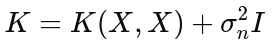




Correlation between Observed Points and New Point

$$\begin{align} K_{star} &= \end{align}$$
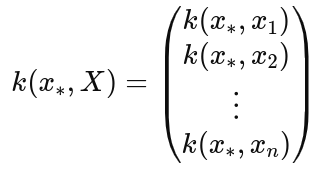

$$\begin{align}K &= L L^T \end{align}$$

The objetive is to solve: $$\begin{align}K α& = Y \end{align}$$

$$\begin{align}L L^T α& = Y \end{align}$$

First we solve:
$$\begin{align}L β & = Y \end{align}$$

$$\begin{align}β &= L^{-1} Y \end{align}$$

Second we solve:
$$\begin{align}L^T α& = β \end{align}$$

$$\begin{align}α& = (L L^T)^{-1} Y = K^{-1} Y \end{align}$$


$$\begin{align}μ_* &= {k_*}^T α \end{align}$$

$$\begin{align}\sigma_*^2 &= k(x_*, x_*)- k_*^T K^{-1}k_* \end{align}$$

To avoid calculate Κ^{-1}


$$\begin{align}L v &= k_* \end{align}$$


$$\begin{align}v &= L^{-1} k_* \end{align}$$

$$\begin{align}\sigma_*^2 &= k(x_*, x_*)- v^T v \end{align}$$

USING EXPONENTIAL KERNEL
Updating hyperparameters. New values:  [3.13833313e-02 3.18603542e+01 5.93394595e-01]


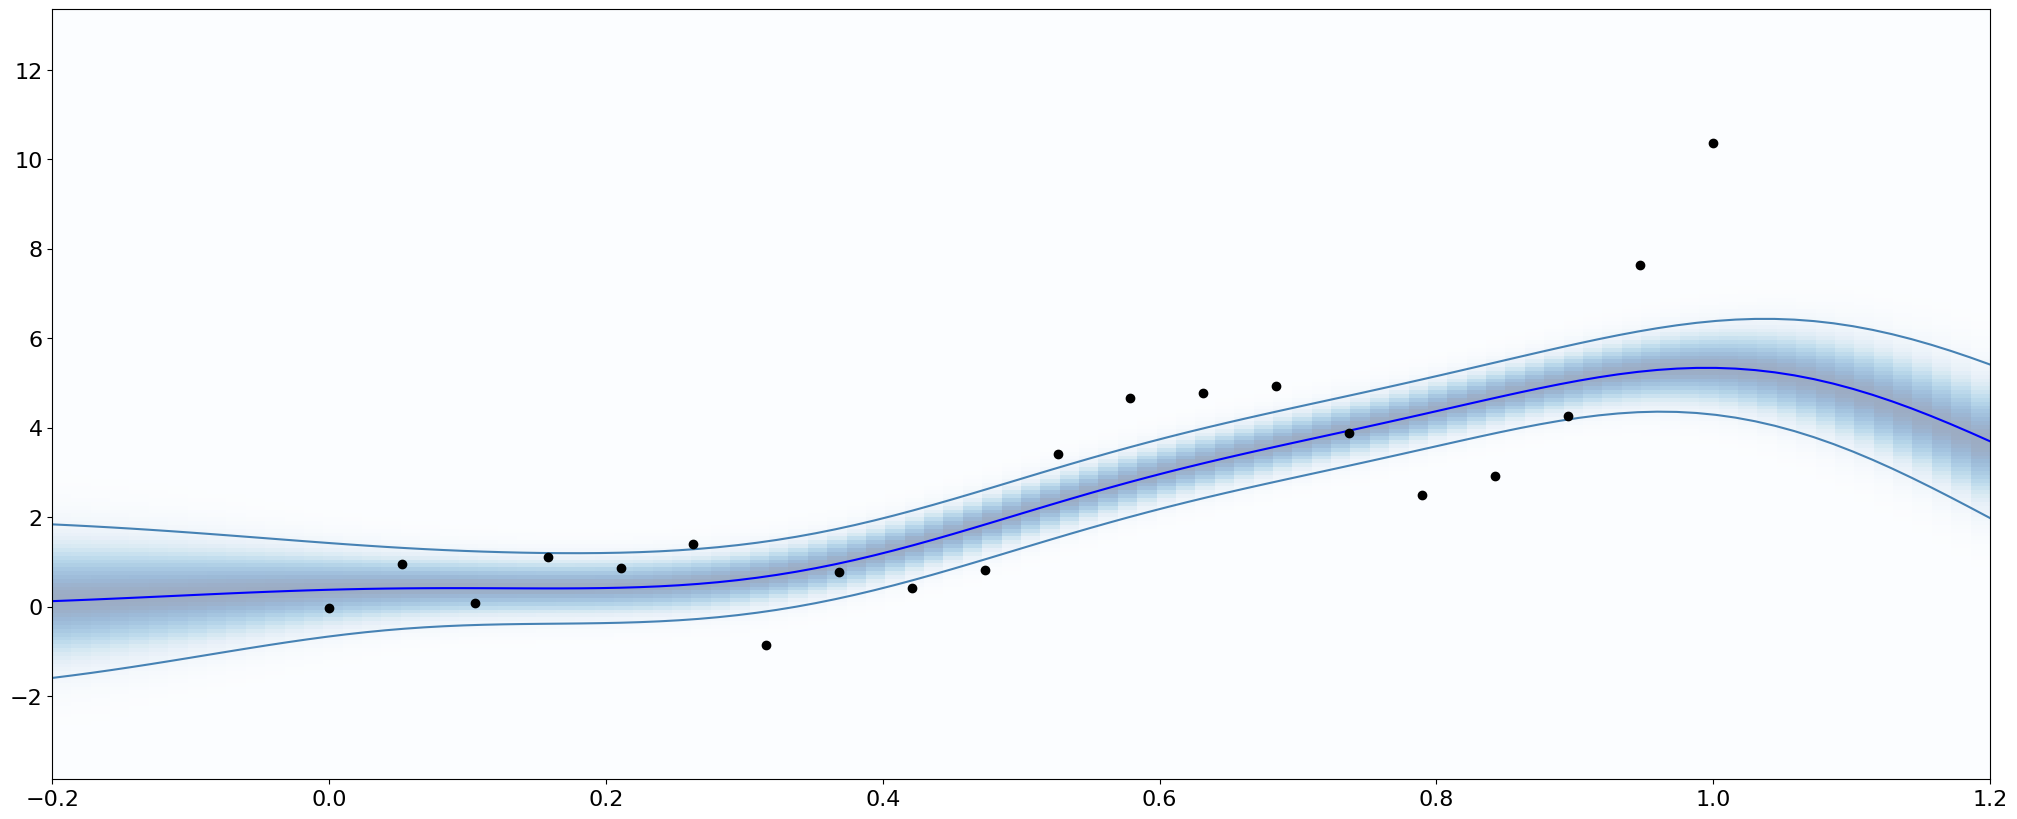

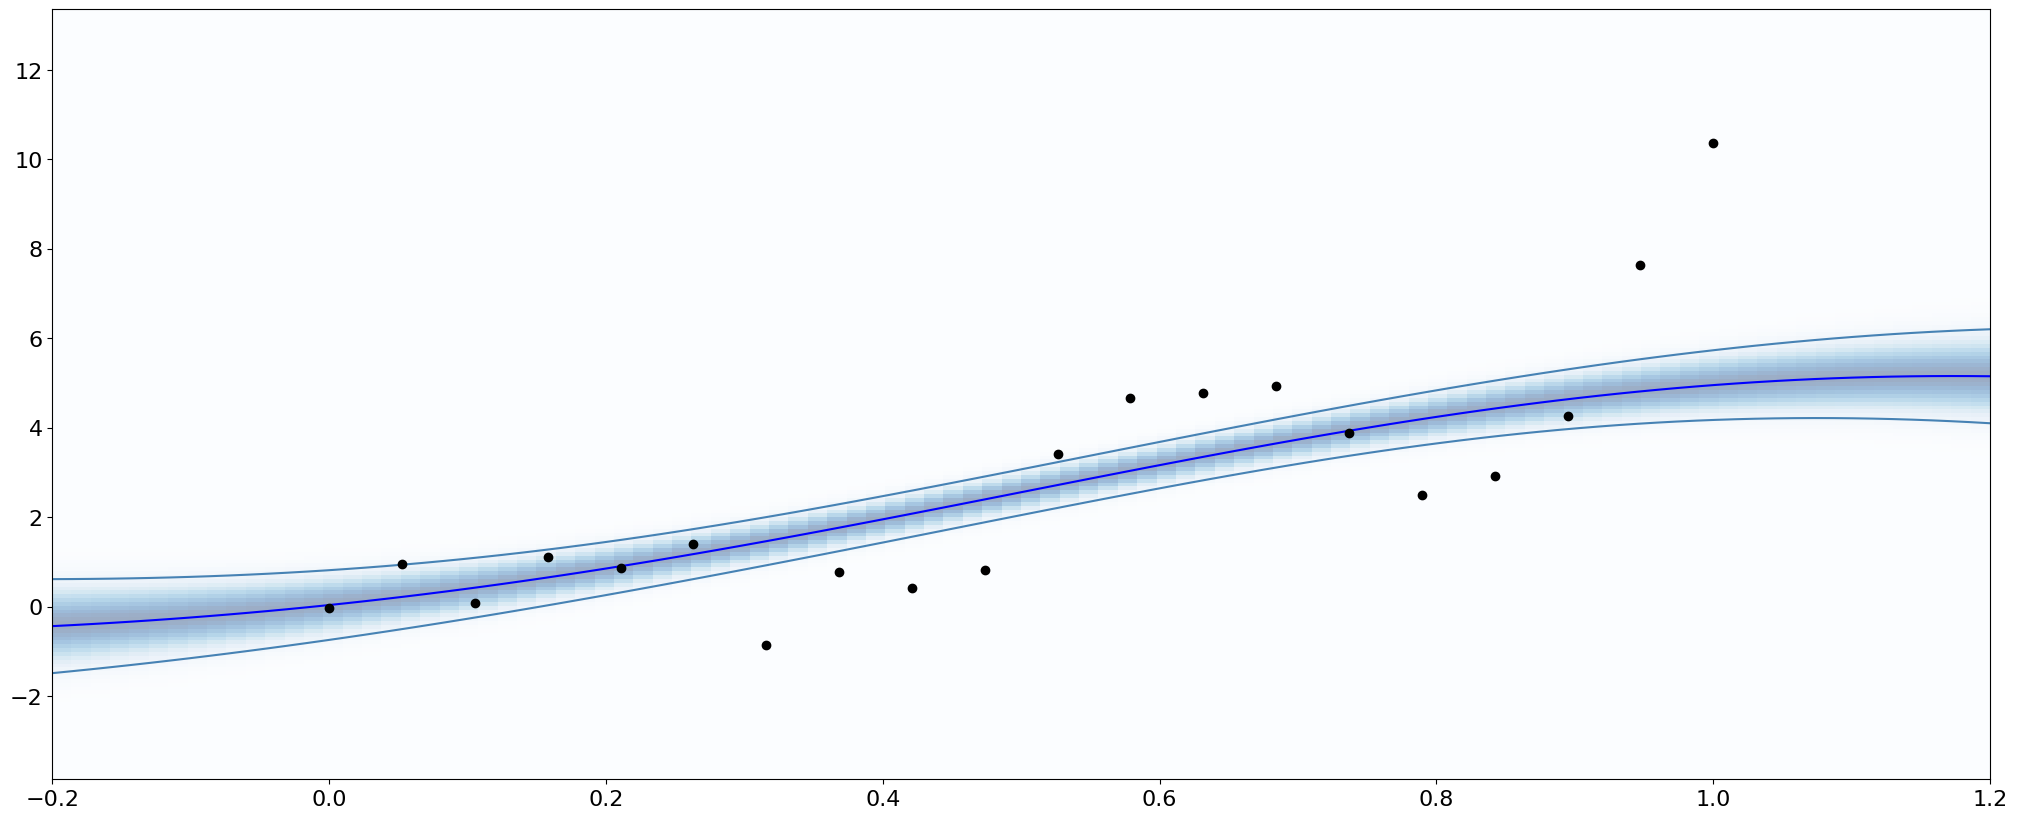

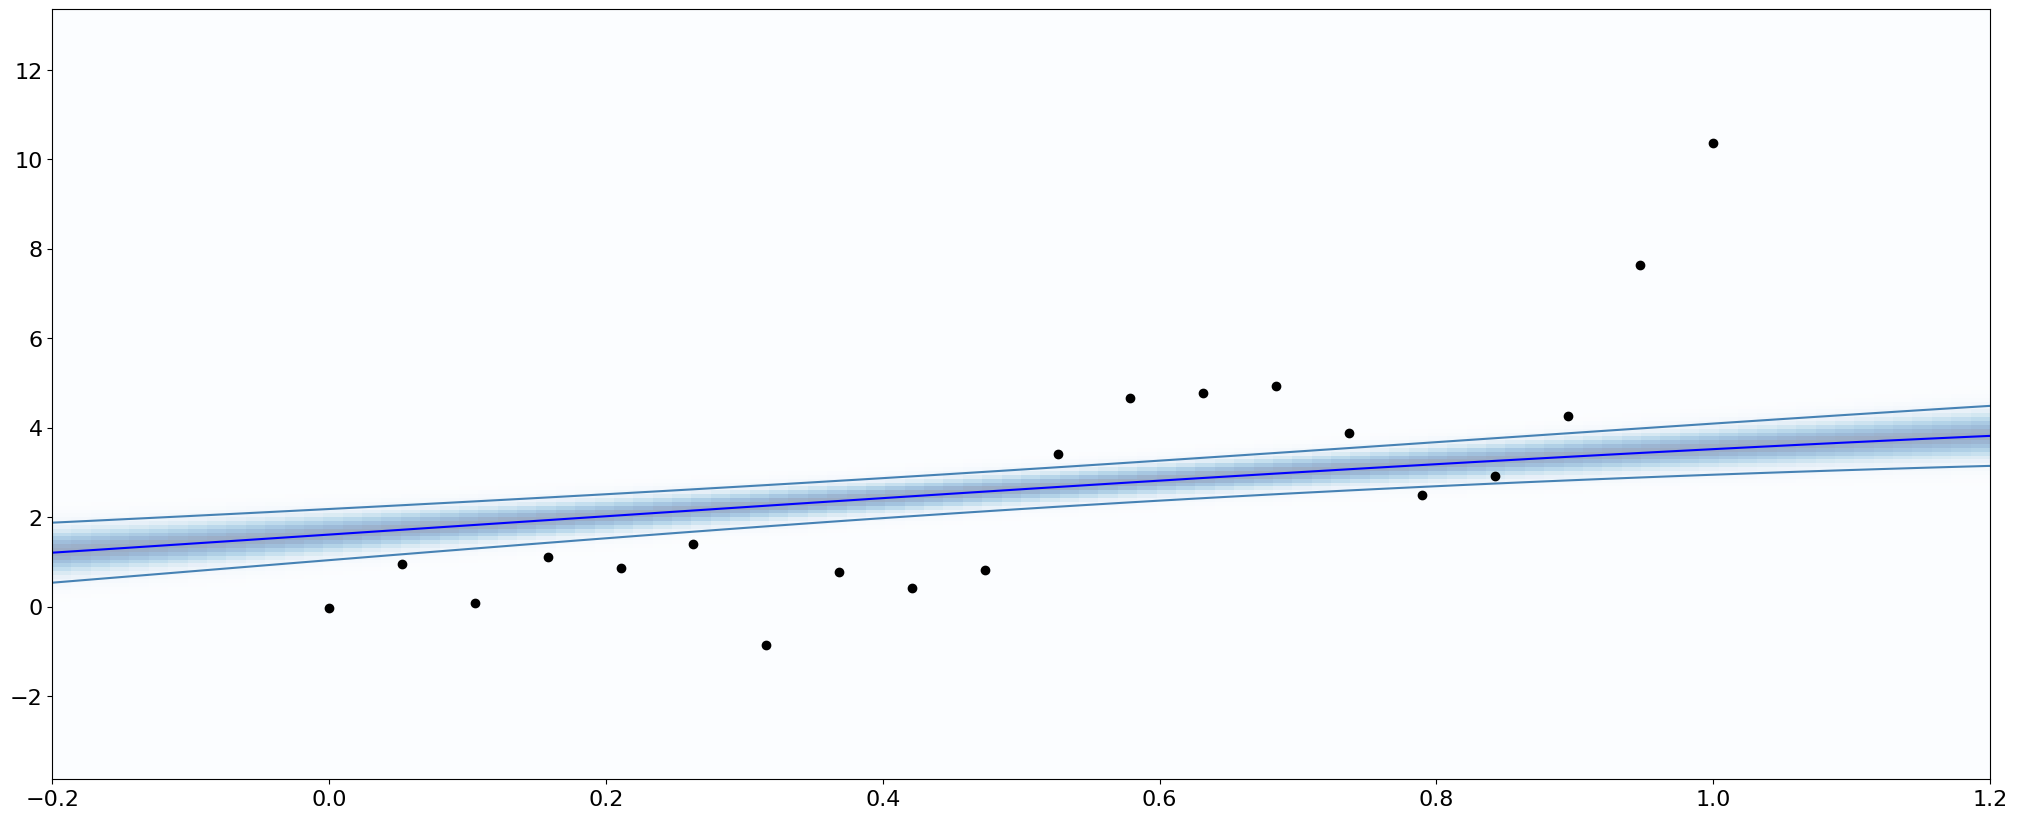

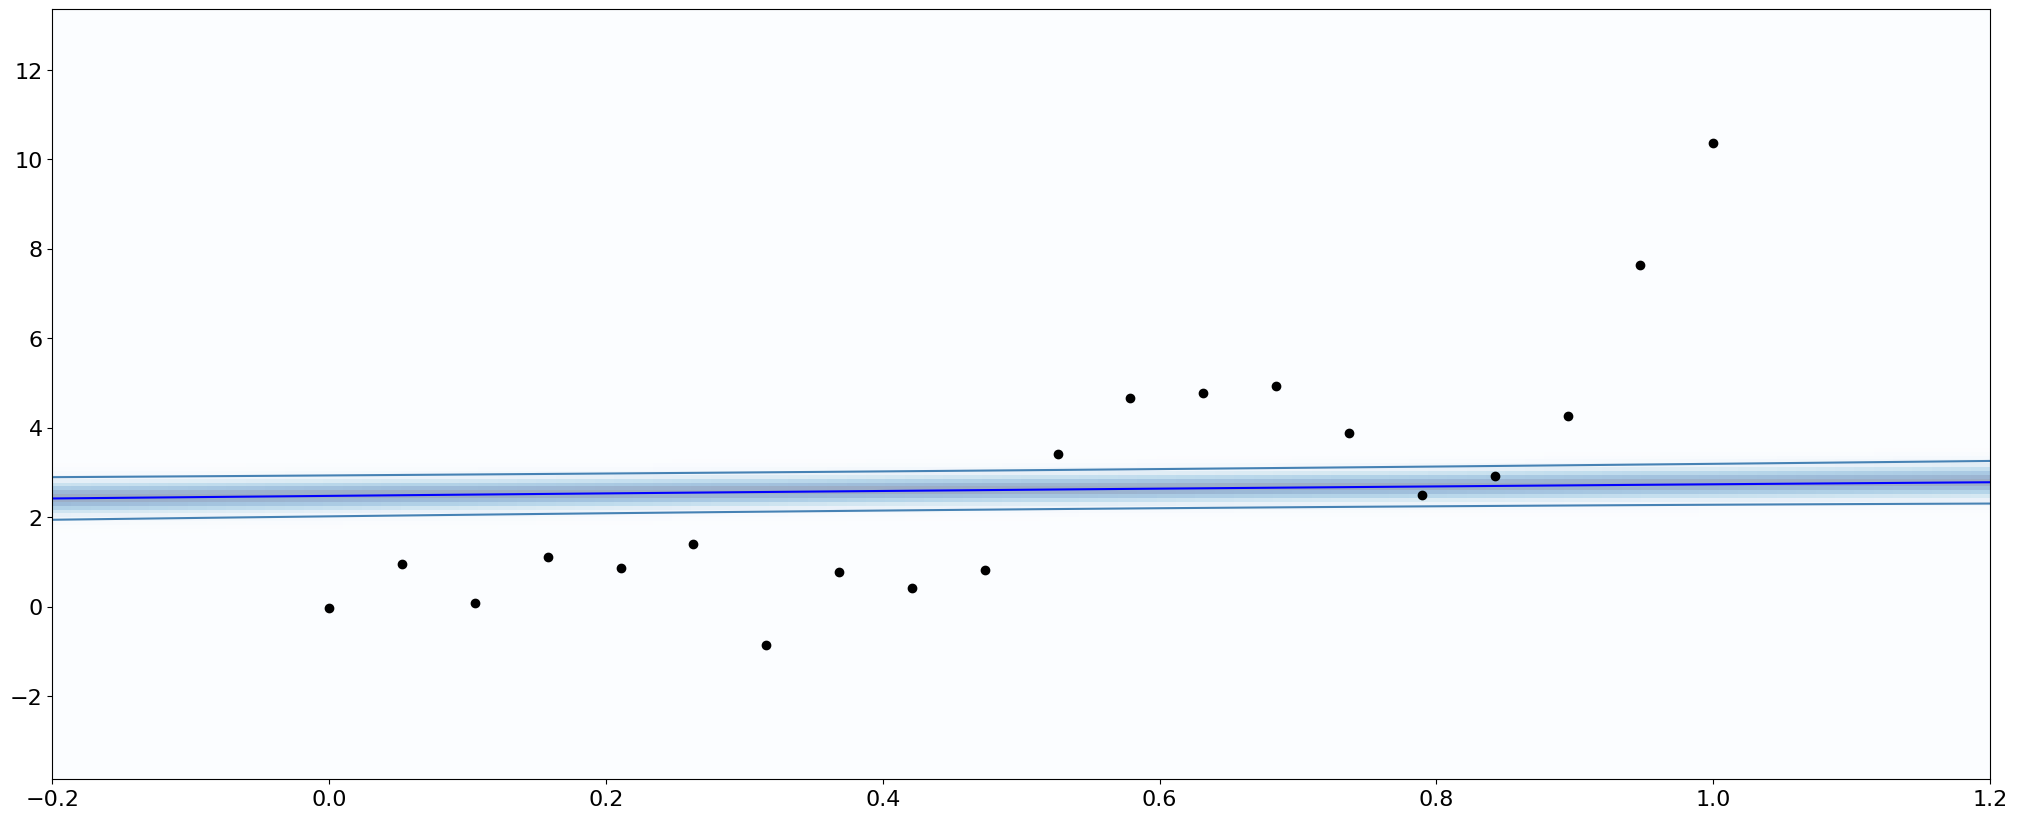

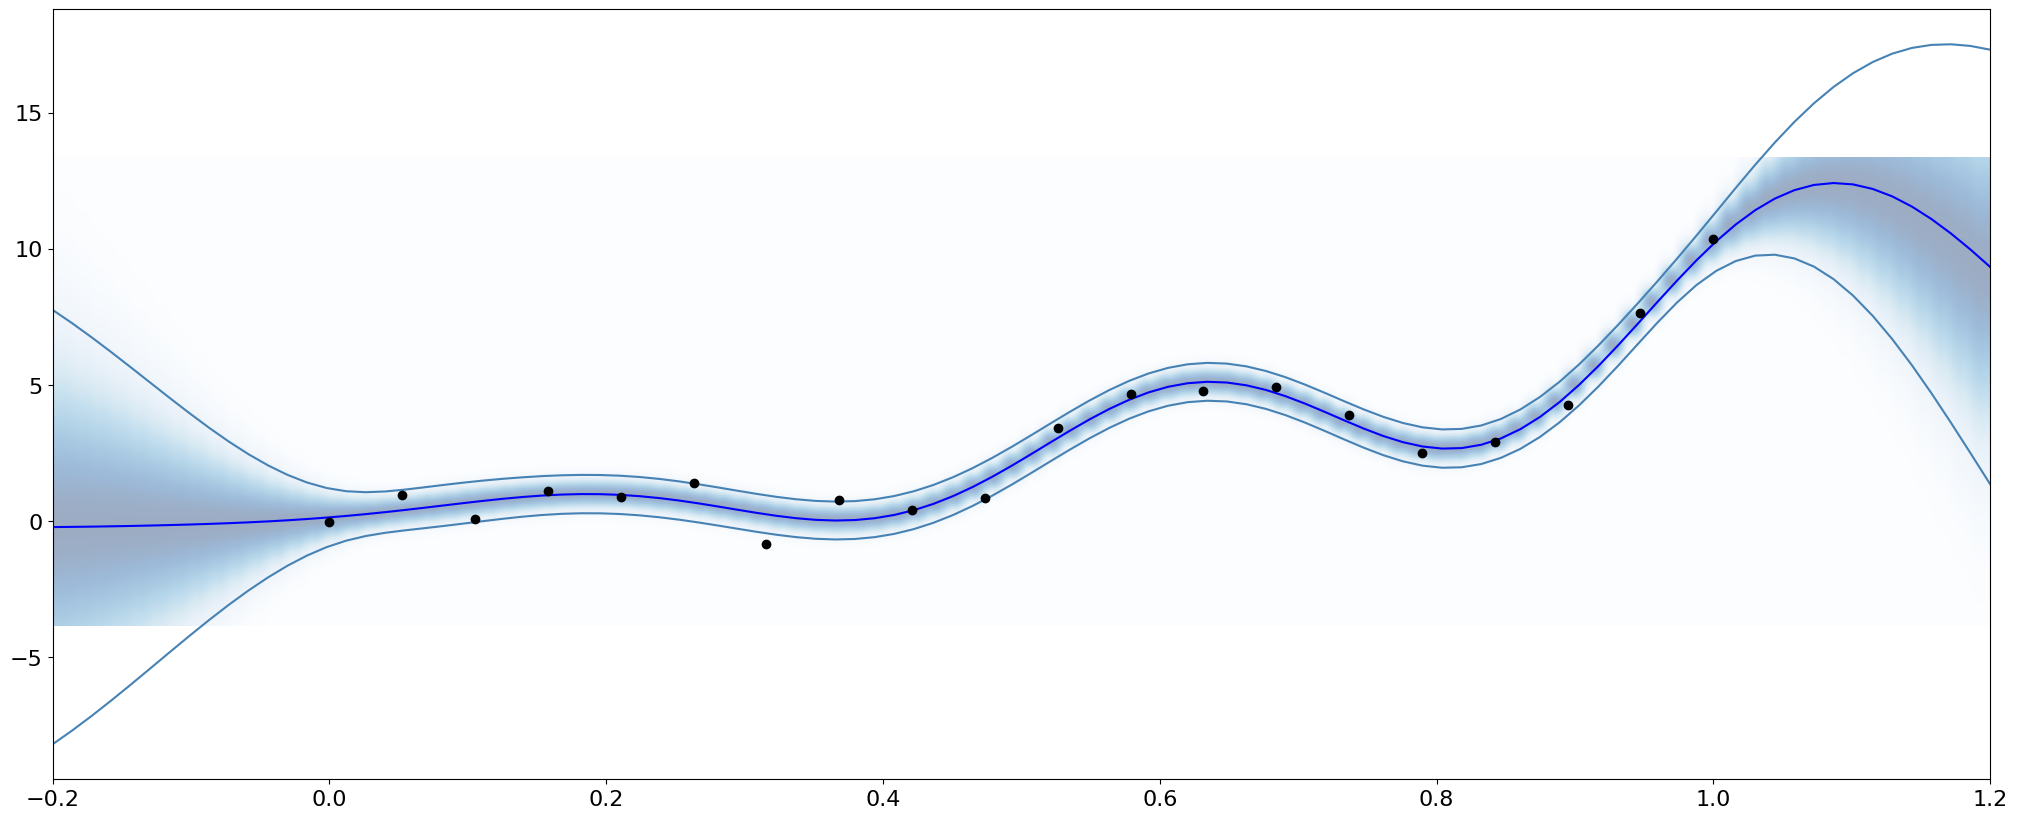

In [18]:
my_gp = GP_cholesky(dataX, dataY, num_kernel=0)
for i in [0.05, 0.5, 5, 50]:
  my_gp.ell = i
  my_gp.plotGP()

my_gp.tune_hyperparameters()
my_gp.plotGP()
plt.show()

With a small ell value (0.05), the GP model is highly sensitive to the data points, leading to a model that follows the data very closely, producing a wavy pattern with high variability.


With a very large ell (50), the GP model is too smooth, capturing almost no variation. The predictions appear almost flat, as the GP regards the influence of each point as minimal.


After tuning the hyperparameters, the GP model automatically selects an optimal length-scale and other parameters. This results in a well-balanced model, with smooth predictions that respect the overall trend of the data while capturing some local variability.

USING MATERN 3/2 KERNEL
Updating hyperparameters. New values:  [ 0.36004911 36.19664753  0.55636756]


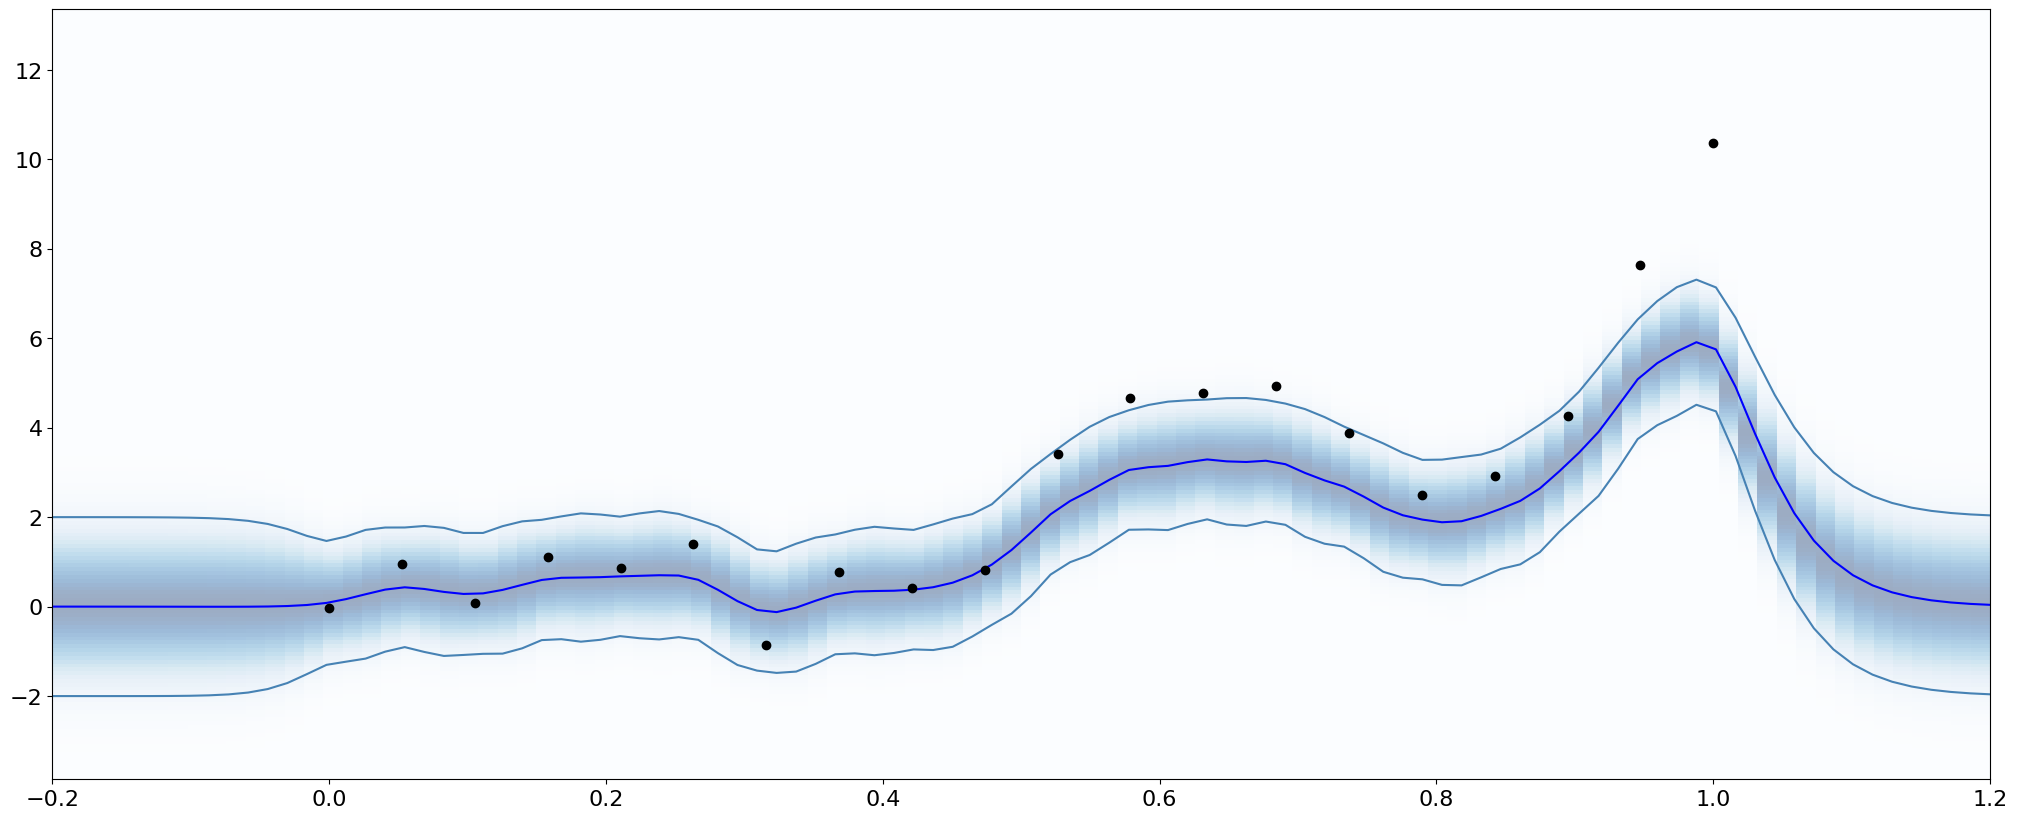

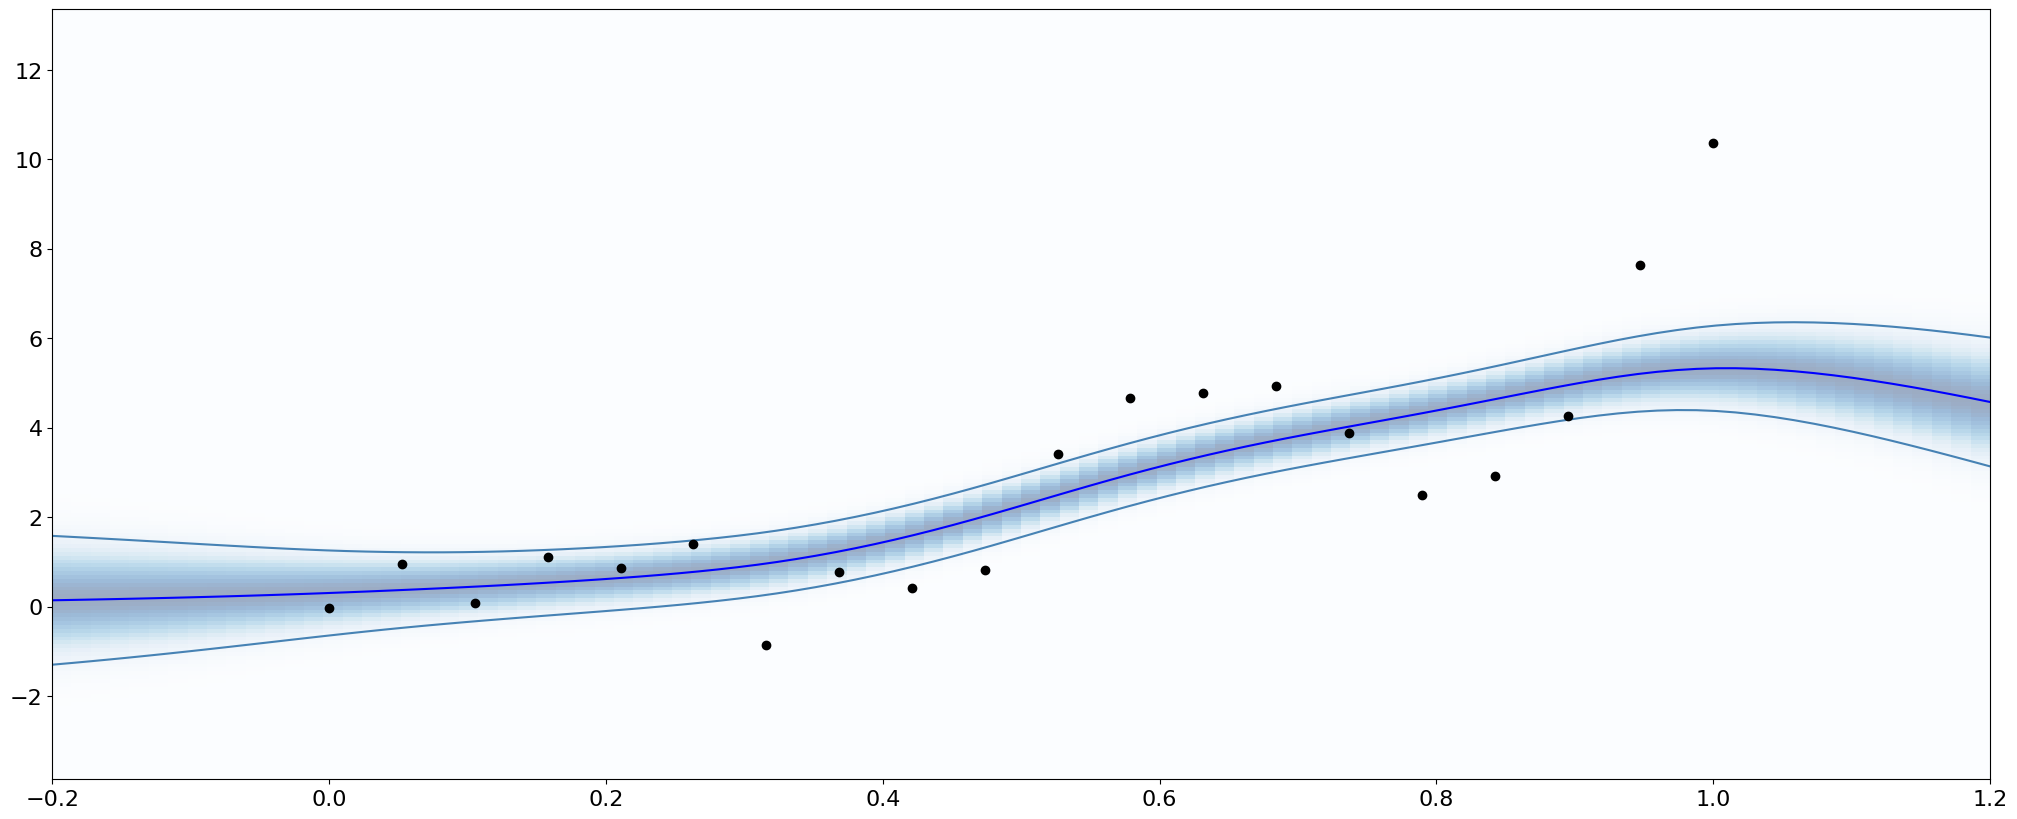

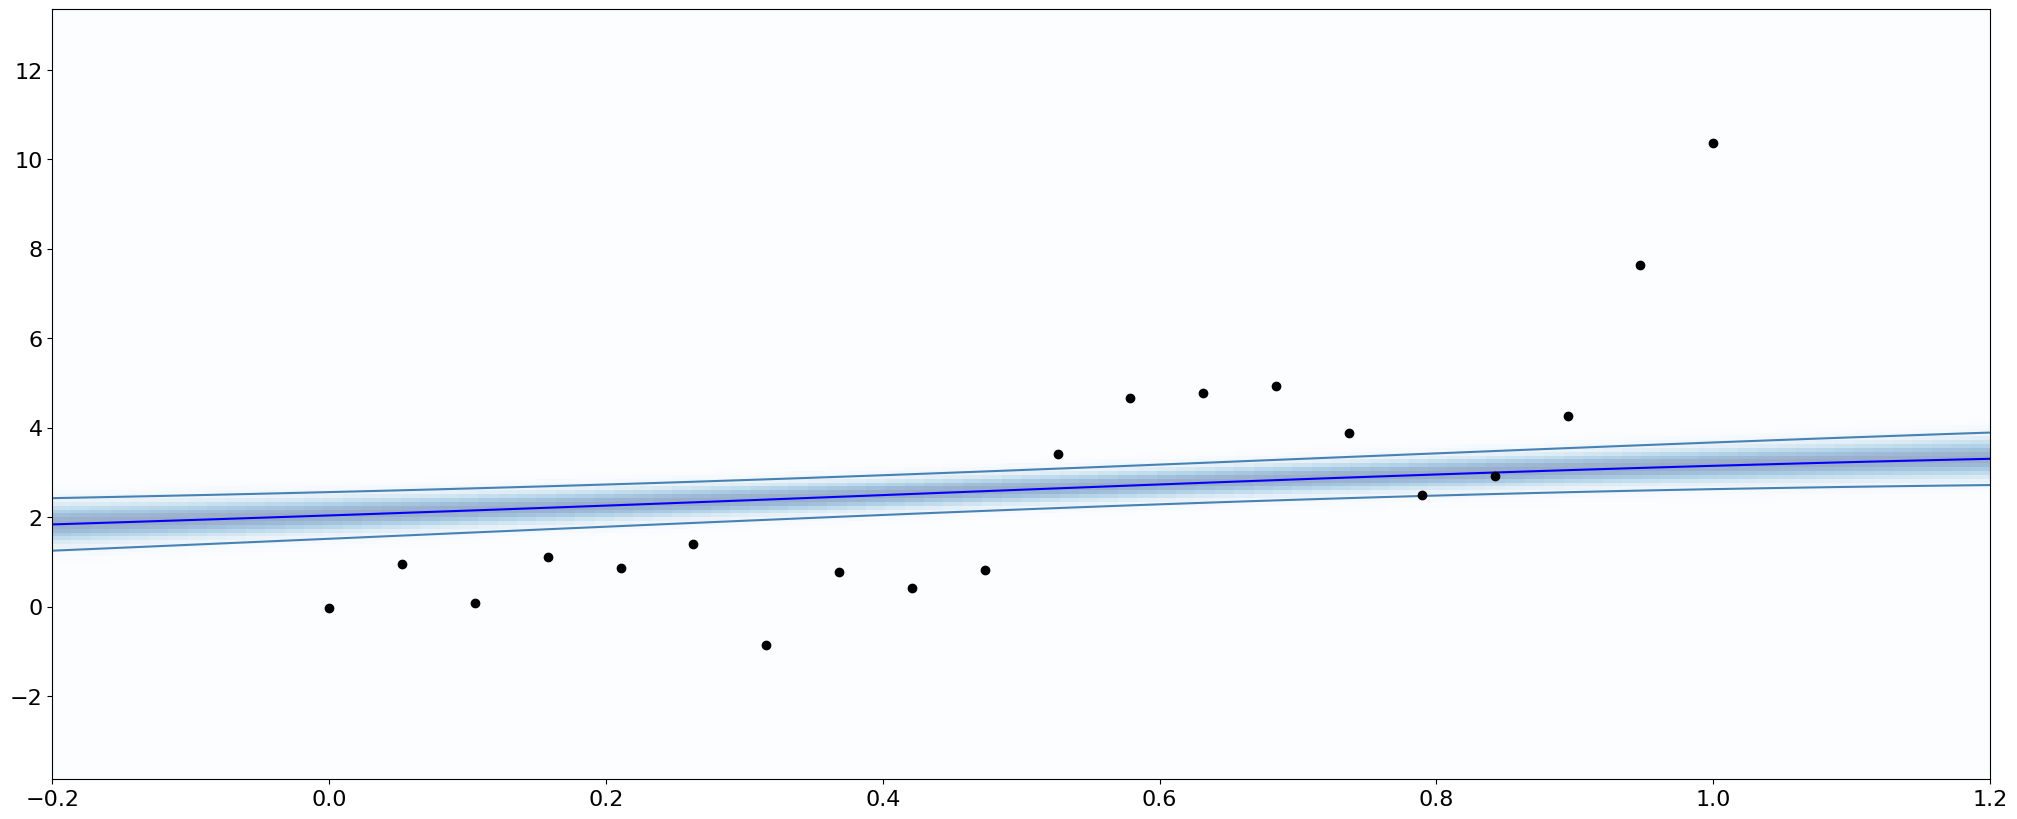

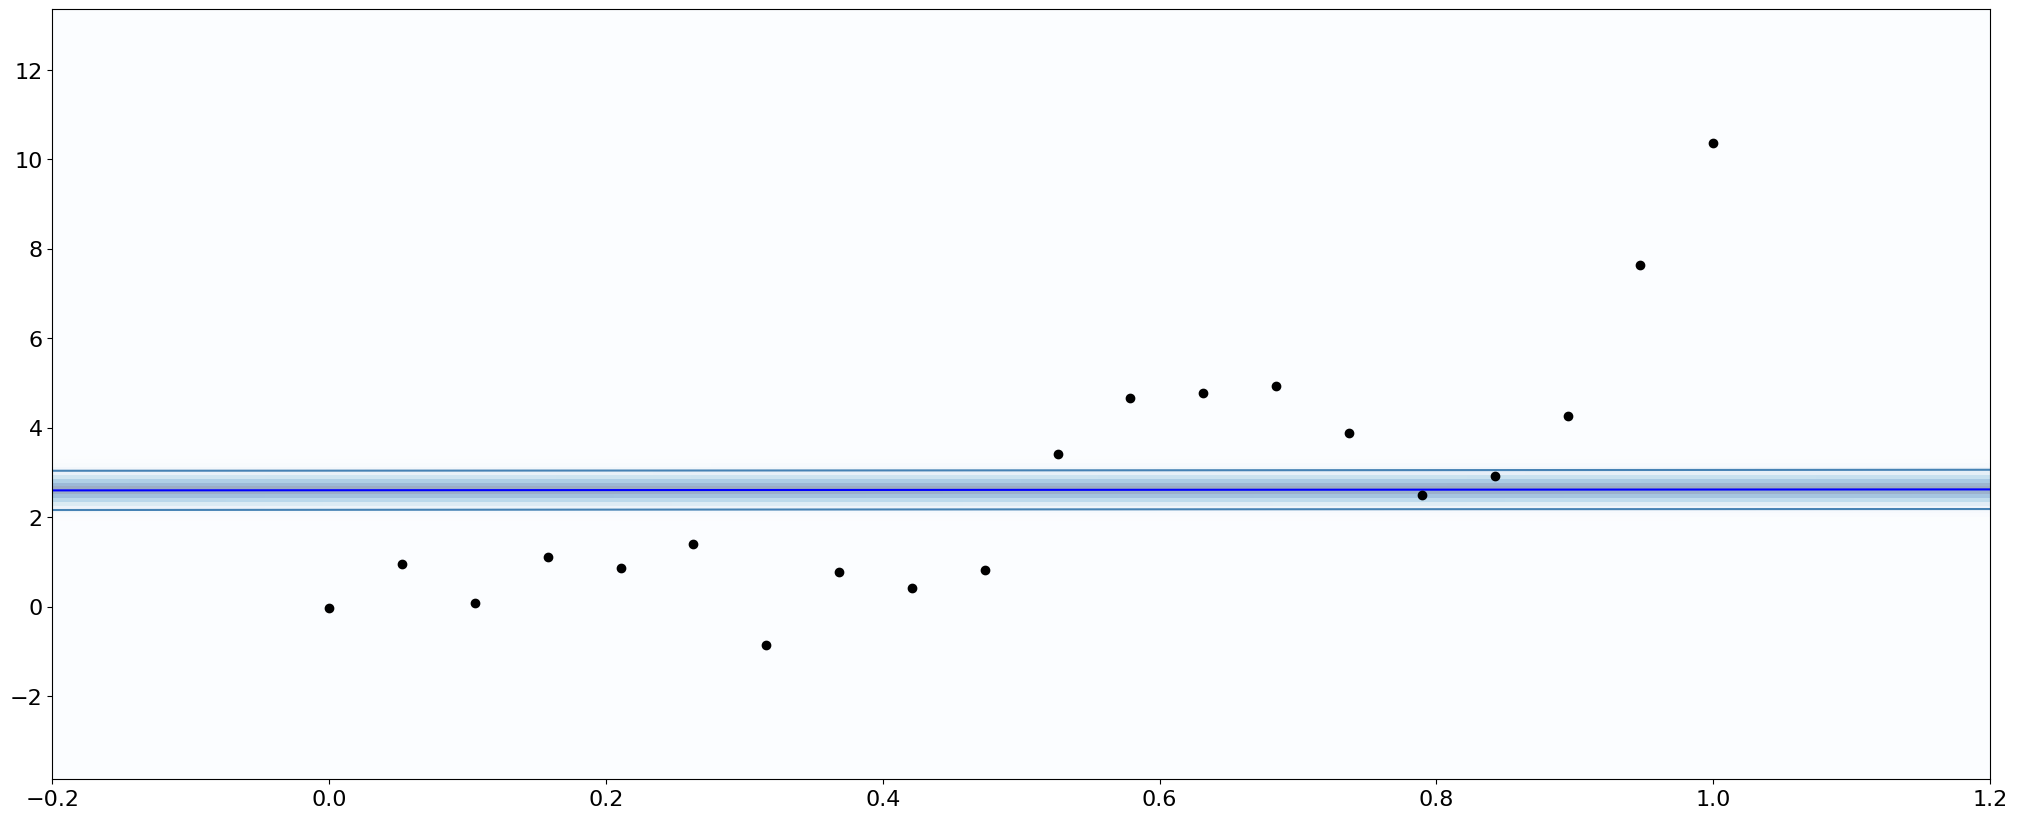

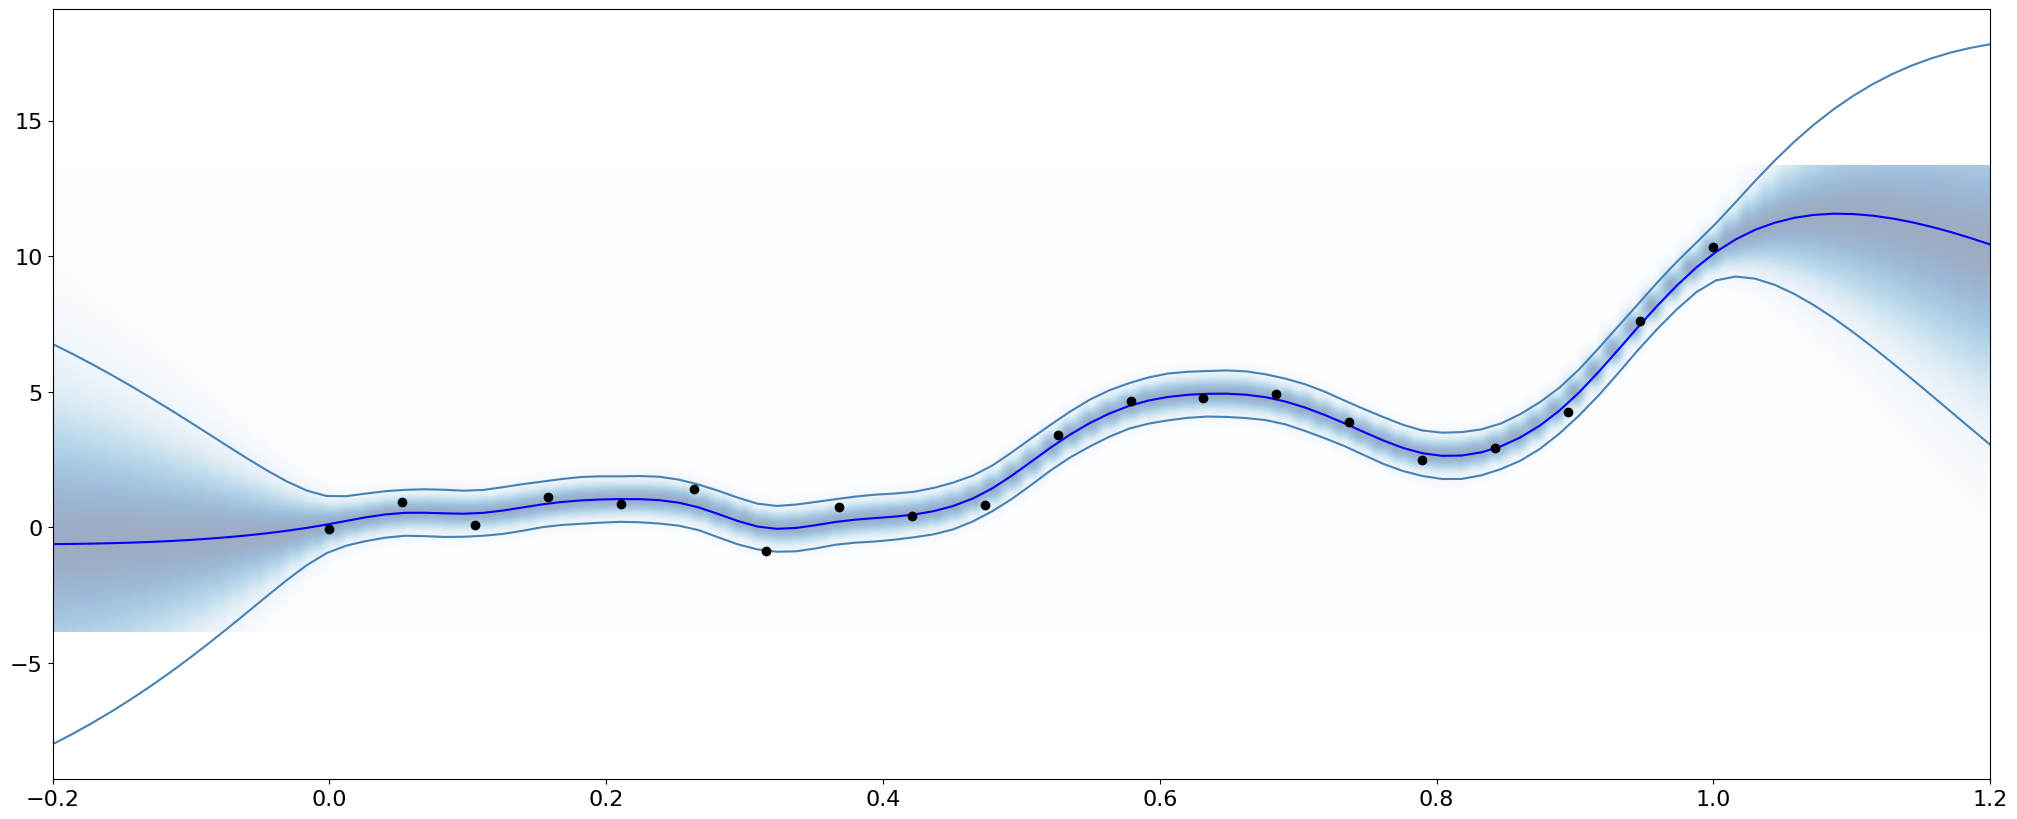

In [19]:
# USING KERNEL MATER 3/2
my_gp = GP_cholesky(dataX, dataY, num_kernel=1)
for i in [0.05, 0.5, 5, 50]:
  my_gp.ell = i
  my_gp.plotGP()

my_gp.tune_hyperparameters()
my_gp.plotGP()
plt.show()

In these results, we've switched from using an Exponential kernel to the Matérn 3/2 kernel for the Gaussian Process model.

 Matérn 3/2 kernel, even smaller ell values tend to produce smoother estimates with less pronounced oscillations compared to the exponential kernel, which tends to produce sharper transitions between points.

 With the Exponential kernel, the confidence intervals tend to be wider in regions without data points, indicating higher uncertainty. The Matérn kernel also shows wider confidence intervals in data-sparse regions but does so with smoother transitions